In [1]:
from glob import glob

import krippendorff
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score, classification_report, ConfusionMatrixDisplay
import farrow_and_ball as fb

In [2]:
import functools

# plt set default parameters
plt.rcParams.update(plt.rcParamsDefault)
#set plt log level to info
plt.set_loglevel('INFO')


def plot_confusion_matrix(y_true, y_pred, labels, cmap=None, colorbar=False):
    if cmap is None:
        cmap = fb.build_colormap(fb.BaseColorPalette.PINKS, continuous=True, reverse=False)
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels, cmap=cmap, ax=ax, colorbar=colorbar)
    # return partial function to plot confusion matrix
    return disp.plot(ax=ax, cmap=cmap, colorbar=colorbar)


def judgements_evaluation_report(eval_df, true_col='true', predicted_col='predicted'):
    print(classification_report(eval_df[true_col], eval_df[predicted_col], labels=[0, 1, 2, 3]))
    _k = krippendorff.alpha(eval_df[[true_col, predicted_col]].T, level_of_measurement='ordinal',
                            value_domain=[0, 1, 2, 3])
    _kappa = cohen_kappa_score(eval_df[true_col], eval_df[predicted_col])
    _pearson = np.corrcoef(eval_df[true_col], eval_df[predicted_col])[0, 1]
    _kendall = kendalltau(eval_df[true_col], eval_df[predicted_col]).correlation
    _mae = np.abs(eval_df[true_col] - eval_df[predicted_col]).mean()
    return _k, _kappa, _pearson, _kendall, _mae


def eval_predictions(predictions_df, model_name, true_col='true', predicted_col='predicted', labels=(0, 1, 2, 3)):
    _k, _kappa, _pearson, _kendall, _mae = judgements_evaluation_report(predictions_df, true_col=true_col,
                                                                        predicted_col=predicted_col)
    print(f"Krippendorff's alpha for {model_name} on the validation set: {_k:.3f}")
    print(f"Cohen's kappa for {model_name} on the validation set: {_kappa:.3f}")
    print(f"Pearson correlation for {model_name} on the validation set: {_pearson:.3f}")
    print(f"Kendall's tau for {model_name} on the validation set: {_kendall:.3f}")
    print(f"Mean Absolute Error (MAE) for {model_name} on the validation set: {_mae:.3f}")

    plot_confusion_matrix(predictions_df[true_col], predictions_df[predicted_col], labels=labels)
    plt.title(model_name, fontsize='small')
    plt.savefig(f'plots/{model_name}_cm.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [22]:
# load validation df
# val_qrel_df = pd.read_table('test-qrel-1.txt', header=None, delim_whitespace=True,
#                             names=['qid', 'Q0', 'docid', 'relevance']).drop(columns=['Q0'], errors='ignore').set_index(
#     ['qid', 'docid']).sort_index()
# val_qrel_df

val_qrel_df = pd.read_table('val_set_qrel.tsv', delim_whitespace=True)
val_qrel_df

,qid,Q0,docid,relevance
0,q26,0,p1668,0
1,q26,0,p3564,0
2,q26,0,p148,0
3,q26,0,p10159,1
4,q26,0,p4522,0
...,...,...,...,...
1726,q48,0,p11513,0
1727,q48,0,p9676,0
1728,q48,0,p688,0
1729,q48,0,p8574,3


In [23]:
def read_predictions_df(file_path, val_qrel_df, rsplit=False) -> pd.DataFrame:
    raw_output_df = pd.concat([pd.read_table(f) for f in glob(file_path)])
    if rsplit:
        _temp_df = raw_output_df['prediction'].str.rsplit(',', n=1, expand=True)
        raw_output_df = raw_output_df.assign(
            predicted=_temp_df[1].str.split(':', n=1, expand=True)[1].str.strip().str.strip(
                '"}').astype(int),
            explanation=_temp_df[0].str.split(':', n=1, expand=True)[1].str.strip().str.strip(
                '"}'))
    else:
        _temp_df = raw_output_df['prediction'].str.split(',', n=1, expand=True)
        raw_output_df = raw_output_df.assign(
            predicted=_temp_df[0].str.split(':', n=1, expand=True)[1].str.strip().astype(int),
            explanation=_temp_df[1].str.split(':', n=1, expand=True)[1].str.strip().str.strip(
                '"}'))
    raw_output_df = raw_output_df.join(val_qrel_df.set_index(['qid', 'docid']), on=['qid', 'docid'])
    return raw_output_df.drop(columns=['prediction'])

In [39]:
file_path = 'p-mult-1_Meta-Llama-3-70B-Instruct.tsv'
mult_llama70 = pd.read_table(file_path).drop(columns='Q0').join(val_qrel_df.set_index(['qid', 'docid']),
                                                                on=['qid', 'docid'])
mult_llama70

,qid,docid,explanation,prediction,Q0,relevance
0,q26,p1668,Mentions the Caribbean in the context of a bir...,1,0,0
1,q26,p3564,Provides specific information about the locati...,2,0,0
2,q26,p148,Appears to be a citation for a research paper,0,0,0
3,q26,p10159,Mentions the Caribbean coastline in the contex...,1,0,1
4,q26,p4522,Focused on a specific location and a wildlife ...,1,0,0
...,...,...,...,...,...,...
1726,q48,p11513,Directly answers the query with a once-weekly ...,3,0,0
1727,q48,p9676,"Unrelated to the query, discussing general wor...",0,0,0
1728,q48,p688,Discusses ideal frequency of strength training...,2,0,0
1729,q48,p8574,Focuses on a specific exercise and its frequency,1,0,3


              precision    recall  f1-score   support

           0       0.84      0.35      0.49       975
           1       0.25      0.31      0.28       390
           2       0.17      0.53      0.26       188
           3       0.37      0.51      0.43       178

    accuracy                           0.38      1731
   macro avg       0.41      0.42      0.36      1731
weighted avg       0.59      0.38      0.41      1731

Krippendorff's alpha for LLAMA-70 Multi Passage on the validation set: 0.262
Cohen's kappa for LLAMA-70 Multi Passage on the validation set: 0.172
Pearson correlation for LLAMA-70 Multi Passage on the validation set: 0.423
Kendall's tau for LLAMA-70 Multi Passage on the validation set: 0.359
Mean Absolute Error (MAE) for LLAMA-70 Multi Passage on the validation set: 0.907


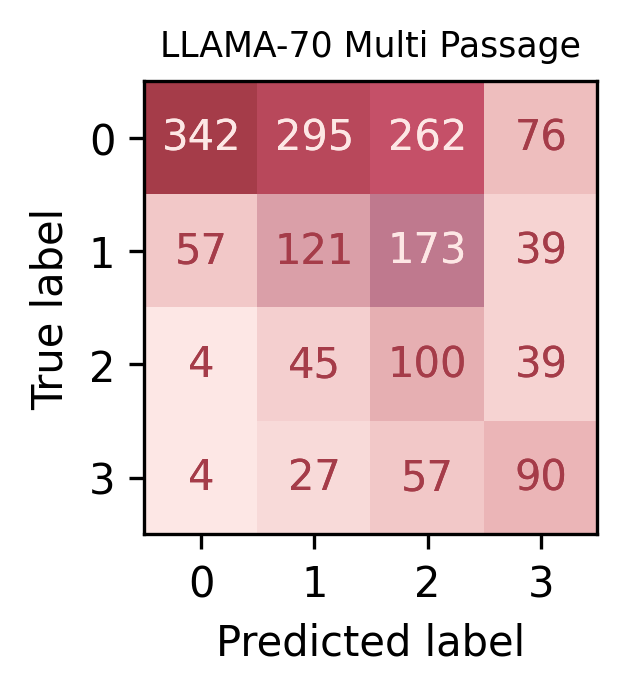

In [43]:
eval_predictions(mult_llama70, 'LLAMA-70 Multi Passage', true_col='relevance', predicted_col='prediction')

In [25]:
file_path = 'llm_raw_output/raw_output_rel_p-mult-1_Meta-Llama-3-70B-Instruct_*.tsv'
# file_path = 'llm_raw_output/raw_output_rel_p-mult-1-test_Meta-Llama-3-8B-Instruct_*.tsv'
# file_path = 'llm_raw_output/raw_output_rel_p-mult-1-test_Meta-Llama-3-70B-Instruct_*.tsv'
raw_output_df = pd.concat([pd.read_table(f) for f in glob(file_path)])
for x in raw_output_df.iloc[0]:
    print(x)

q48
['p10319', 'p4495', 'p4314']
Here is my evaluation:
     The order of the passages is: doc-2, doc-1, doc-3.
     The reason for this order is that doc-2 directly answers the query, providing evidence that older adults can gain strength by training once per week. Doc-1 is also related to the query, but it doesn't directly answer it, instead comparing the effects of different training frequencies. Doc-3 is less relevant, as it discusses the effectiveness of different training frequencies, but doesn't specifically address the query.

     {"pid": "doc-2", "explanation": "Directly answers the query", "relevance": 3}
     {"pid": "doc-1", "explanation": "Related to the query, but doesn't directly answer it", "relevance": 2}
     {"pid": "doc-3", "explanation": "Less relevant, discusses training frequencies in general", "relevance": 1}


In [26]:
def rel_parse(label):
    common_parse = {'1': 1, '2': 2, '3': 3, '"2"': 2, '"1"': 1, '"3"': 3, '2},': 2, '1},': 1, '3},': 3}
    return common_parse.get(label, 0)


def drop_duplicates(df):
    return df[~df.index.duplicated(keep='first')]


_temp_df = raw_output_df['prediction'].str.split('{').str[1:].apply(''.join)
_record_d = []
failed = []
for (qid, docid), text in zip(raw_output_df[['qid', 'docid']].itertuples(index=False), _temp_df):
    _records = text.split('\n')
    docid = [i.strip() for i in docid[1:-1].replace("'", "").split(',')]
    map_docid = {f'doc-{i}': d for i, d in enumerate(docid, 1)}
    for _record in _records:
        if not _record:
            continue
        try:
            _, pid, explanation, relevance = _record.split(':')
            pid = pid.rsplit(',')[0].strip().strip('\"')
            explanation = explanation.rsplit(',', maxsplit=1)[0].strip().strip('\"')
            relevance = relevance.strip().strip('}')
            _record_d.append(
                dict(qid=qid, docid=map_docid.get(pid), explanation=explanation, predicted=rel_parse(relevance)))
        except Exception as e:
            # print(e)
            failed.append(_record)
            continue
print(f'Failed to parse {len(failed)} records')
parsed_df = pd.DataFrame(_record_d).set_index(['qid', 'docid']).sort_index()
parsed_df = drop_duplicates(parsed_df)
parsed_df

Failed to parse 2 records


explanation  predicted
qid docid                                                               
q10 p1                             directly answers the query          3
    p10016  Directly mentions low level flying as a tactic...          3
    p1005   pilots flying low to demonstrate aircraft's co...          2
    p10061                                                             1
    p10068  Discusses regulations and investigations relat...          2
...                                                       ...        ...
q48 p9852                              Unrelated to the query          0
    p9880                                                              1
    p9950                        Directly addresses the query          3
    p999    Discusses workout schedules, but not relevant ...          0
    p9998                          Directly answers the query          3

[1709 rows x 2 columns]

In [27]:
# find duplicates
_df = val_qrel_df.join(parsed_df, on=['qid', 'docid'], how='left')
dups = (_df.index.value_counts() > 1).index[:4]

In [28]:
parsed_df = val_qrel_df.join(parsed_df, on=['qid', 'docid'], how='left').fillna(0)
parsed_df['predicted'] = parsed_df['predicted'].astype(int)
parsed_df

,qid,Q0,docid,relevance,explanation,predicted
0,q26,0,p1668,0,Mentions the Caribbean in the context of a bir...,1
1,q26,0,p3564,0,Provides specific information about the locati...,2
2,q26,0,p148,0,Appears to be a citation for a research paper,0
3,q26,0,p10159,1,Mentions the Caribbean coastline in the contex...,1
4,q26,0,p4522,0,Focused on a specific location and a wildlife ...,1
...,...,...,...,...,...,...
1726,q48,0,p11513,0,Directly answers the query with a once-weekly ...,3
1727,q48,0,p9676,0,"Unrelated to the query, discussing general wor...",0
1728,q48,0,p688,0,Discusses ideal frequency of strength training...,2
1729,q48,0,p8574,3,Focuses on a specific exercise and its frequency,1


In [31]:
# parsed_df.drop(columns='relevance').rename(columns={'predicted':'prediction'}).to_csv('p-mult-1_Meta-Llama-3-70B-Instruct.tsv', sep='\t', index=False)

In [10]:
for i in failed[:5]:
    print(i)

print(_record.split(':'))
# list(map(lambda s: s.split(':')[1].strip().strip('\"').strip('}'), _record.split(',')))

"doc-1", "The passages are not related to the query, they are about different movies.", "relevance": 0}
    "doc-2", "The passage is about the movie 'A Wrinkle in Time' and contains information about the movie's cast and crew.", "relevance": 2}
    "doc-3", "The passage is about the same movie and provides behind-the-scenes information.", "relevance": 2}
"doc-1": "The most relevant passage, as it directly mentions the movie's box office earnings.", "relevance": 3}
"doc-2": "The passage provides the exact box office earnings of the movie.", "relevance": 2}
['     "pid"', ' "doc-3", "explanation"', ' "talks about the October 3rd meaning of a person\'s strengths, not relevant to the query", "relevance"', ' 0}']


In [11]:
parsed_df.loc[parsed_df['predicted'] == '']

,,relevance,explanation,predicted
qid,docid,,,


              precision    recall  f1-score   support

           0       0.76      0.47      0.58      2258
           1       0.32      0.23      0.27      1274
           2       0.17      0.36      0.23       504
           3       0.19      0.51      0.28       387

    accuracy                           0.39      4423
   macro avg       0.36      0.39      0.34      4423
weighted avg       0.52      0.39      0.42      4423

Krippendorff's alpha for llama_test on the validation set: 0.289
Cohen's kappa for llama_test on the validation set: 0.168
Pearson correlation for llama_test on the validation set: 0.382
Kendall's tau for llama_test on the validation set: 0.344
Mean Absolute Error (MAE) for llama_test on the validation set: 0.954


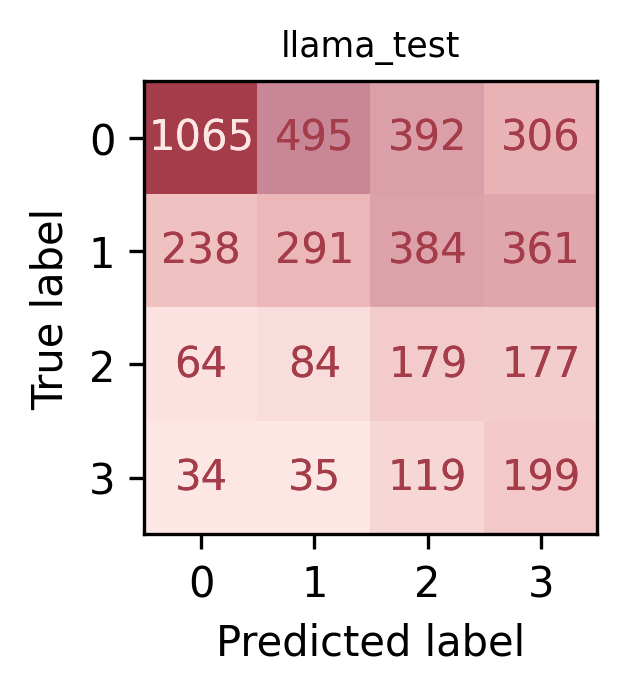

In [12]:
eval_predictions(parsed_df, 'llama_test', true_col='relevance', predicted_col='predicted')

In [13]:
parsed_df = parsed_df.assign(Q0=0)
parsed_df.reset_index()[['qid', 'Q0', 'docid', 'predicted']].to_csv('test-qrel-llama8-multi.txt', index=False,
                                                                    header=False, sep=' ')

In [14]:
llama70 = pd.read_table('test-qrel-llama70-multi.txt', header=None, delim_whitespace=True,
                        names=['qid', 'Q0', 'docid', 'relevance'])
llama8 = pd.read_table('test-qrel-llama8-multi.txt', header=None, delim_whitespace=True,
                       names=['qid', 'Q0', 'docid', 'relevance'])
gpt4_1 = pd.read_table('test-qrel-1.txt', header=None, delim_whitespace=True, names=['qid', 'Q0', 'docid', 'relevance'])
gpt4_2 = pd.read_table('test-qrel-2.txt', header=None, delim_whitespace=True, names=['qid', 'Q0', 'docid', 'relevance'])
# fuse the predictions
avg_fused = llama70.copy()
avg_fused['predicted'] = (
        (llama70['relevance'] + llama8['relevance'] + gpt4_1['relevance'] + gpt4_2['relevance']) / 4).round(0).astype(
    int)
avg_fused.to_csv('test-qrel-avg-fused.txt', index=False, header=False, sep=' ')
avg_fused.value_counts('predicted')

predicted
1    1704
2    1364
0    1276
3      79
Name: count, dtype: int64

In [15]:
med_fused = llama70.copy()
# fuse as the median, within the data
_all_scores = pd.concat([llama70['relevance'], llama8['relevance'], gpt4_1['relevance'], gpt4_2['relevance']], axis=1)
_all_scores.columns = ['llama70', 'llama8', 'gpt4_1', 'gpt4_2']
med_fused['predicted'] = _all_scores.median(axis=1).round(0).astype(int)
med_fused.to_csv('test-qrel-med-fused.txt', index=False, header=False, sep=' ')
med_fused.value_counts('predicted')

predicted
0    1763
2    1389
1    1165
3     106
Name: count, dtype: int64

In [16]:
wavg_fused = llama70.copy()
wavg_fused['predicted'] = ((0.25 * llama70['relevance'] + 0.15 * llama8['relevance'] + 0.3 * gpt4_1[
    'relevance'] + 0.3 * gpt4_2['relevance'])).round(0).astype(int)
wavg_fused.to_csv('test-qrel-wavg-fused.txt', index=False, header=False, sep=' ')
wavg_fused.value_counts('predicted')

predicted
1    2245
0    1138
2     922
3     118
Name: count, dtype: int64

In [17]:
gpt_avg_fused = llama70.copy()
gpt_avg_fused['predicted'] = ((0.5 * gpt4_1['relevance'] + 0.5 * gpt4_2['relevance'])).round(0).astype(int)
gpt_avg_fused.to_csv('test-qrel-gpt-avg-fused.txt', index=False, header=False, sep=' ')
gpt_avg_fused.value_counts('predicted')

predicted
0    2510
1     954
2     691
3     268
Name: count, dtype: int64